# Classifying Cats vs Dogs with a Convolutional Neural Network on Kaggle

This notebook details the code to create a Convolution Neural Network to classify pictures as either dogs or cats.

Competition and data can be found here https://www.kaggle.com/c/dogs-vs-cats
Guide to CNN can be found here https://pythonprogramming.net/convolutional-neural-network-kats-vs-dogs-machine-learning-tutorial/

In [1]:
# Import matplotlib library and set dark mode
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
plt.style.use('dark_background')

# Change theme of notebook to dark mode
from jupyterthemes import get_themes
from jupyterthemes.stylefx import set_nb_theme
set_nb_theme('monokai')

!pip install opencv-python
import os, cv2 # cv resize image. os for directories 
import numpy as np
import pandas as pd

from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm  # shows visual when loop running 

# Tensor Flow neural network library
!pip install tflearn 
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
import tensorflow as tf

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


Define global variables and model tuning hyperparamaters

In [2]:
# Directories created for train and test images 
TRAIN_DIR = r"C:\Users\richard.dudbridge\Documents\Python Scripts\Dogs Vs Cats\dogs-vs-cats\train\train"
TEST_DIR = r"C:\Users\richard.dudbridge\Documents\Python Scripts\Dogs Vs Cats\dogs-vs-cats\test1\test1"

IMG_SIZE = 50 # 50 x 50 - this is the resizing of all images to this size
LR = 1e-3 # Learning rate (step size for iterations)

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # Tells us which model is saved

Let's convert the 'dog' and 'cat' labels to binary values:

In [3]:
# Takes the 'cat' or 'dog' label from the image title
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    if word_label == 'cat': return [1,0]
    elif word_label == 'dog': return [0,1]

Now let's create function to convert images and labels into arrays

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)): # tqmd gives progress bar
        label = label_img(img) # specifies the label name
        path = os.path.join(TRAIN_DIR,img) # specifies the directory for the images
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE) # turns image into greyscale
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))  # resize image to specified dimensions (50x50)
        training_data.append([np.array(img),np.array(label)]) # convert everything to the array
    shuffle(training_data) # shuffle data to avoid overfitting
    np.save('train_data.npy', training_data) # saves the trained data (so you don't need to run this function again)
    return training_data

And create a function to convert test data into arrays (so we can process the test data for submission)

In [5]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

Load training data from the image files downloaded from the Kaggle competition page

In [6]:
train_data = create_train_data() # Run function to load data

100%|██████████| 25000/25000 [02:58<00:00, 139.92it/s]
C:\Users\richard.dudbridge\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
# Create CNN network. 5 convolutional layers
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

# Split the data into train and test
train = train_data[:-500]
test = train_data[-500:]

# Reshape image arrays in desired shape so they can be fed into the model 
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

# Fit model to inputs (pictures process into arrays)
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 1148  | total loss: 0.49843 | time: 36.381s
| Adam | epoch: 003 | loss: 0.49843 - acc: 0.7505 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.49647 | time: 37.478s
| Adam | epoch: 003 | loss: 0.49647 - acc: 0.7520 | val_loss: 0.48772 - val_acc: 0.7500 -- iter: 24500/24500
--


The model hit an accuracy of 75%. This could be improved by tuning paramaters and modifying the neural network

Now let's save the model and plot some of the pictures with labels from the model to test how well it works

In [8]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\richard.dudbridge\dogsvscats-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 12500/12500 [00:40<00:00, 309.80it/s] 


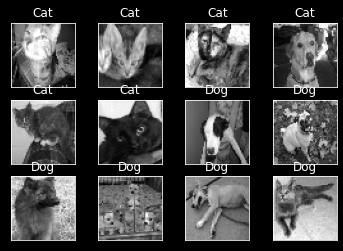

In [9]:
test_data = process_test_data()

fig = plt.figure()

for num, data in enumerate(test_data[:12]):
    # cat = [1,0]
    # dog = [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label = 'Dog'
    else: str_label = 'Cat'
        
    y.imshow(orig, cmap ='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()
        

Run the model on the test images for the competition and save the result as a csv on the local computer

In [10]:
with open('submission-file.csv','w') as f:
    f.write('id,label\n')

with open('submission-file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]      
        orig = img_data
        data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|██████████| 12500/12500 [00:22<00:00, 552.74it/s]
